# Step 0 - Load Packages

Link to offical Lifetimes Package documentation: https://lifetimes.readthedocs.io/en/latest/index.html

In [1]:
############################################
# Author: Jillian Stoller 
# pCLV using Lifetimes Package 
# Last Updated 5/28/23
############################################

################################ LOAD PACKAGES ################################

import pandas as pd
import numpy as np
import datetime
from datetime import datetime, timedelta
from scipy import stats 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
from cycler import cycler

from matplotlib import rc #importing different font styles for the visuals
#import latex
rc('font',**{'family':'sans-serif','sans-serif':['gill sans']})
rc('text', usetex=False)

from sklearn.metrics import mean_absolute_percentage_error

#import pip 
%pip install lifetimes
%pip install latex
#python pip install Ghostscript

from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import \
    calibration_and_holdout_data, \
    summary_data_from_transaction_data, \
    calculate_alive_path
from lifetimes.plotting import \
    plot_frequency_recency_matrix, \
    plot_probability_alive_matrix, \
    plot_period_transactions, \
    plot_history_alive, \
    plot_cumulative_transactions, \
    plot_calibration_purchases_vs_holdout_purchases, \
    plot_transaction_rate_heterogeneity, \
    plot_dropout_rate_heterogeneity, \
    plot_expected_repeat_purchases


import warnings
warnings.filterwarnings("ignore")


# Display Max Column Width in tables
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)


%matplotlib inline
sns.set(rc={'image.cmap': 'coolwarm'})
sns.set_style("whitegrid") #preferred visual style



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Step 1 - Upload Dataset & Enter Column Name Info - User Input Required

Uploading Cleaned Dataset

In [2]:
################################ USER INPUT ################################
#load in data

data = pd.read_csv('pCLV_input.csv')

data.head()

,USER_NO,PURCHASE_DATE,PURCHASE_VALUE
0,adc51319aea81d6970834fb9ac7e7f828495d3f170a38bfd8be52af318f5ccb0,2022-12-31,188.80
1,9deeaf4a996b1b9aa26fde0b223995e088540f798390eab2ee1f5c272bccfcf0,2022-12-31,526.65
2,595e6f7d70e77a591449e179825ea55e7b88512b305fe0552a20e2788c9f6f70,2022-12-31,"2,071.02"
3,9a47224ac2cad5106becb8e1301963b23a62e8df7efe724148f5753e23de70f6,2022-12-31,250.00
4,c5f866297aba26eb0d6b17bf4e220ca371435675c4bea4eff2564e43c3bd0b80,2022-12-31,"1,543.10"


In [3]:
################################ START OF USER INPUT ################################
DATE_COLUMN = "PURCHASE_DATE" #update date column name
CUSTOMER_ID_COLUMN = "USER_NO" #update Customer ID column name
REVENUE_COLUMN = "PURCHASE_VALUE"#update Revenue column name
transaction_name = "Orders" #update name to appear on charts ex(Revenue, Orders, etc.)
customer_name = "Customer" #update name to appear on charts ex(Customer, Subscriber, Rewards Member, etc.)
freq = 'D' # use D for days, W for weeks, or h for hours
t_holdout = 100  # days to reserve for holdout period (do not recommend <100)
chart_colors =  ["#7f58af","#feb326", "#e84d8a"] #accent color for the plots. 

################################ END OF USER INPUT ################################

## Step 2 - Data Cleaning & Model Preparation

Calibration Period: 01-01-2021 to 09-22-2022
Holdout Period: 09-23-2022 to 12-31-2022
68.10% of customers make a repeat order


,frequency,recency,T,monetary_value
count,"34,839.00","34,839.00","34,839.00","34,839.00"
mean,9.39,94.02,366.10,"2,217.29"
std,26.68,158.33,218.08,"15,647.00"
min,0.00,0.00,0.00,0.00
25%,0.00,0.00,171.00,0.00
50%,2.00,10.00,356.00,207.78
75%,7.00,117.00,566.00,"1,106.17"
max,632.00,726.00,729.00,"1,814,194.00"


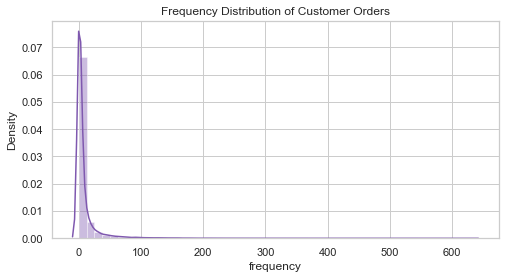

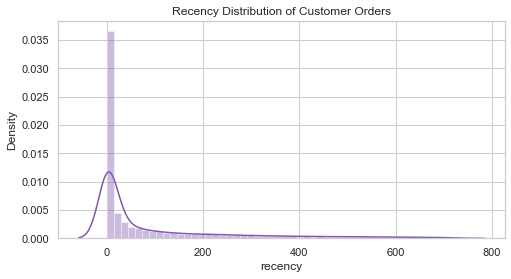

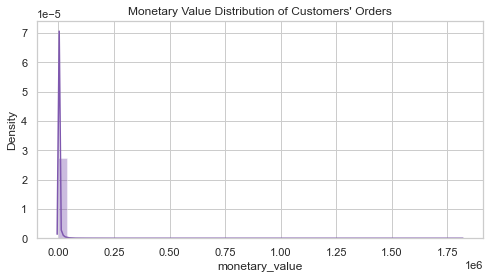

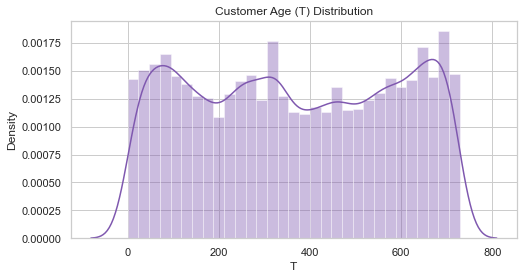

In [4]:
#set the plots to cycle through the brand colors
mpl.rcParams['axes.prop_cycle'] = cycler(color = chart_colors)

#make sure dates are datetime with the European format (dayfirst = True)
data[DATE_COLUMN]= pd.to_datetime(data[DATE_COLUMN])

#make sure revenue col are numeric
data[REVENUE_COLUMN]= pd.to_numeric(data[REVENUE_COLUMN])

#make sure there are only positive values in revenue column
data = data[data[REVENUE_COLUMN] > 0]

#sort data by Customer ID & the Date Column
data = data.sort_values([CUSTOMER_ID_COLUMN, DATE_COLUMN], ascending = (False, True))

#reset index
data = data.reset_index()

#last date of data
obs_period_end_date = data[DATE_COLUMN].max()

#end date of chosen calibration period
max_cal_date = obs_period_end_date - timedelta(days=t_holdout)
#max_cal_date = obs_period_end_date - datetime.timedelta(days=t_holdout)

#use lifetimes package to transform the transaction data into necessary format
summary = summary_data_from_transaction_data(
                                            transactions = data,
                                            customer_id_col = CUSTOMER_ID_COLUMN, 
                                            datetime_col = DATE_COLUMN, 
                                            monetary_value_col = REVENUE_COLUMN, 
                                            observation_period_end = obs_period_end_date, 
                                            freq = freq)

#table for returning customers - will be used later
returning_customers_summary = summary[summary['frequency']>0]



'''

Recency: the number of time periods (days/weeks) since a customer’s latest transactions
Frequency: the number of time periods, after the initial purchase, when the customer buys again
Monetary Value: the average value of the customer’s transactions (revenues or profit per transaction)
Customer age T: the number of time periods since the customer’s first purchase

'''

sns.set_style("whitegrid") #preferred visual style

#frequency distribution
fig = plt.figure(figsize=(8, 4)) 
ax = sns.distplot(summary["frequency"])
ax.set_title("Frequency Distribution of " + customer_name + " " + transaction_name )

#recency distribution
fig = plt.figure(figsize=(8, 4)) 
ax = sns.distplot(summary["recency"])
ax.set_title("Recency Distribution of " + customer_name + " " + transaction_name )

#Monetary Value distribution
fig = plt.figure(figsize=(8, 4)) 
ax = sns.distplot(summary["monetary_value"])
ax.set_title("Monetary Value Distribution of " + customer_name + "s' " + transaction_name)

#T distribution
fig = plt.figure(figsize=(8, 4)) 
ax = sns.distplot(summary["T"])
ax.set_title(customer_name + " Age (T) Distribution" )

print("Calibration Period: " + str(data[DATE_COLUMN].min().strftime('%m-%d-%Y')) + 
      " to " + str((data[DATE_COLUMN].max() - timedelta(days=t_holdout)).strftime('%m-%d-%Y')) + 
     "\nHoldout Period: " + str(((data[DATE_COLUMN].max() - timedelta(days=t_holdout - 1)).strftime('%m-%d-%Y'))) +
     " to " + str(data[DATE_COLUMN].max().strftime('%m-%d-%Y')))


print( (str((len(summary[summary['frequency']>0]) / len(summary) * 100))[0:5] +"% of " + customer_name +
     "s make a repeat " + transaction_name[:-1]).lower())

summary.describe()

# Model Fitting - Calibration (Train) / Holdout (Test) Split

In [5]:
#create columns for each customer. The values will be broken out by which period
#T_cal means the value of T during the calibration period
#T_holdout means the value of T during the holdout period

data_ch = calibration_and_holdout_data(
        transactions = data, 
        customer_id_col = CUSTOMER_ID_COLUMN, 
        datetime_col = DATE_COLUMN,
        monetary_value_col = REVENUE_COLUMN, 
        calibration_period_end = max_cal_date, 
        observation_period_end = obs_period_end_date, 
        freq = freq)  

data_ch.describe()


,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
count,"29,537.00","29,537.00","29,537.00","29,537.00","29,537.00","29,537.00","29,537.00"
mean,8.63,82.24,322.65,"2,335.90",1.88,241.41,100.00
std,24.14,137.79,186.92,"16,714.30",7.53,"2,412.59",0.00
min,0.00,0.00,0.00,0.00,0.00,0.00,100.00
25%,0.00,0.00,161.00,0.00,0.00,0.00,100.00
50%,2.00,8.00,325.00,216.00,0.00,0.00,100.00
75%,6.00,105.00,492.00,"1,160.47",0.00,0.00,100.00
max,535.00,628.00,629.00,"1,814,194.00",100.00,"159,960.00",100.00


# Model Fitting - BG/NGD

Optimization terminated successfully.
         Current function value: -29.280165
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22


,coef,se(coef),lower 95% bound,upper 95% bound
r,0.262,0.002,0.257,0.266
alpha,1.812,0.031,1.751,1.873
a,0.667,0.012,0.643,0.690
b,2.820,0.081,2.662,2.977


<Figure size 864x432 with 0 Axes>

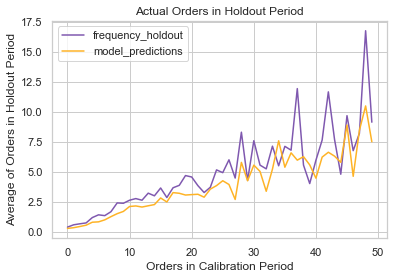

<Figure size 864x864 with 0 Axes>

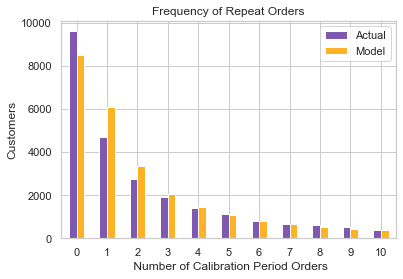

In [6]:
# training: BG/NBD model
bgf = BetaGeoFitter()
bgf.fit(
        frequency = data_ch["frequency_cal"], 
        recency = data_ch["recency_cal"], 
        T = data_ch["T_cal"],   
        weights = None,  
        verbose = True,   
        tol = 1e-06)



# testing: predicted vs actual purchases in holdout period
fig = plt.figure(figsize=(12, 6)) 
plot_calibration_purchases_vs_holdout_purchases(bgf, data_ch, n =50);
plt.xlabel(transaction_name + " in Calibration Period")
plt.ylabel("Average of " + transaction_name + " in Holdout Period")
plt.title("Actual " + transaction_name + " in Holdout Period")

#axis length
#max_freq = int(data_ch["frequency"].max())  #quantile(0.95))          
#max_T = int(data_ch["T"].max())                         
#max_rec = int(data_ch["recency"].max())  
#print(max_freq)

# frequency of repeat transactions: predicted vs actual
fig = plt.figure(figsize=(12, 12))
plot_period_transactions(bgf, max_frequency = 11);
plt.xlabel(" Number of Calibration Period " + transaction_name)
plt.ylabel(customer_name + "s")
plt.title("Frequency of Repeat " + transaction_name)
plt.xticks(rotation=0)



pd.options.display.float_format = '{:,.3f}'.format

bgf.summary

# Fitting Model to Entire Dataset & Predictions

In [7]:
# BG/NBD model
bgf = BetaGeoFitter(penalizer_coef=1e-06)
bgf.fit(
        frequency = summary["frequency"], 
        recency = summary["recency"], 
        T = summary["T"],   
        weights = None,  
        verbose = True,   
        tol = 1e-06)
pd.options.display.float_format = '{:,.3f}'.format
bgf.summary

Optimization terminated successfully.
         Current function value: -33.192292
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22


,coef,se(coef),lower 95% bound,upper 95% bound
r,0.260,0.002,0.256,0.264
alpha,1.858,0.029,1.801,1.915
a,0.628,0.010,0.608,0.648
b,2.756,0.072,2.614,2.897


No handles with labels found to put in legend.


<AxesSubplot:title={'center':'Tracking Cumulative Orders'}, xlabel='date', ylabel='Cumulative Orders'>

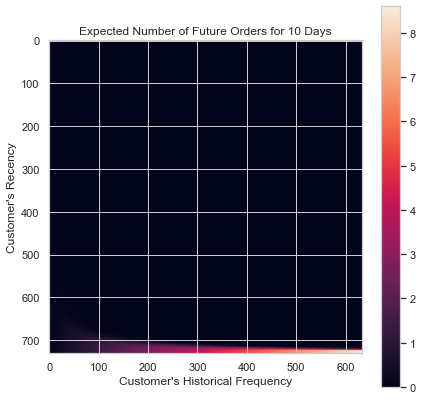

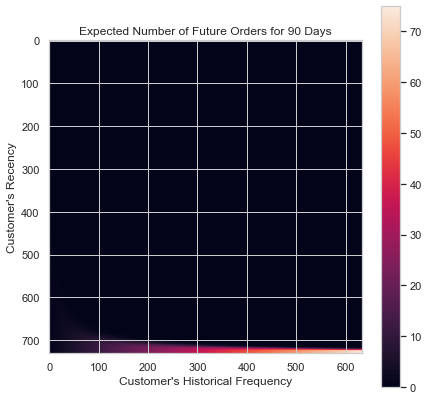

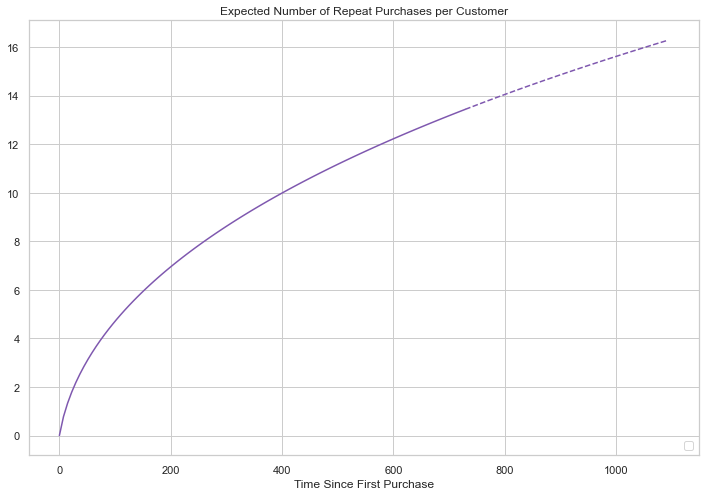

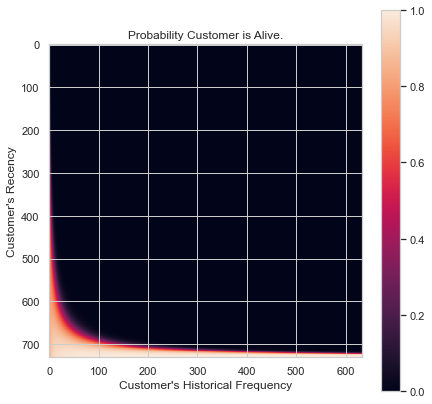

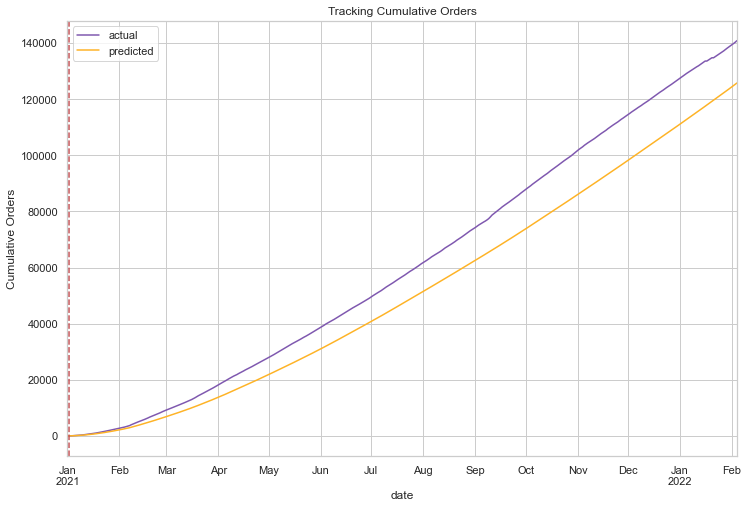

In [8]:
# helper function: plot expected number of future purchases a customer with 
#    frequency f and recency r will make in forecast period

def plot_freq_rec(t):
    fig = plt.figure(figsize=(7, 7)) 
    plot_frequency_recency_matrix(
            model = bgf,   
            T = t,
            xlabel = customer_name + "'s Historical Frequency",
            ylabel = customer_name + "'s Recency",
            title = "Expected Number of Future " + transaction_name + " for " + str(t) + " Days" 
            );
            
            
# call plotter function for different forecast periods:
tFC = [10, 90]
_ = [plot_freq_rec(t) for t in tFC]

#Expected Repeat Purchases
fig = plt.figure(figsize=(12,8))
plot_expected_repeat_purchases(bgf)

#Probability Still Alive
fig = plt.figure(figsize=(7,7))
plot_probability_alive_matrix(bgf, 
                            xlabel = customer_name + "'s Historical Frequency",
                            ylabel = customer_name + "'s Recency",
                            title = "Probability " + customer_name + " is Alive." )


#Cumulative Transactions
fig = plt.figure(figsize=(12,8))
plot_cumulative_transactions(bgf,
                             transactions = data,
                             datetime_col = DATE_COLUMN,
                             customer_id_col = CUSTOMER_ID_COLUMN,
                             t = 400,
                             t_cal = 1,
                             freq = "D",
                             set_index_date = True,
                             xlabel = "Date",
                             ylabel = "Cumulative " + transaction_name,
                             title = "Tracking Cumulative " + transaction_name )

5894 (17.27%) Customers will make at least 1 Order


,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90
count,"34,839.0","34,839.0","34,839.0","34,839.0","34,839.0","34,839.0","34,839.0","34,839.0"
mean,9.4,94.0,366.1,"2,217.3",0.2,0.5,1.0,1.4
std,26.7,158.3,218.1,"15,647.0",0.7,1.9,3.5,5.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,171.0,0.0,0.0,0.0,0.0,0.0
50%,2.0,10.0,356.0,207.8,0.0,0.0,0.0,0.1
75%,7.0,117.0,566.0,"1,106.2",0.0,0.1,0.3,0.4
max,632.0,726.0,729.0,"1,814,194.0",9.5,28.3,55.9,82.7


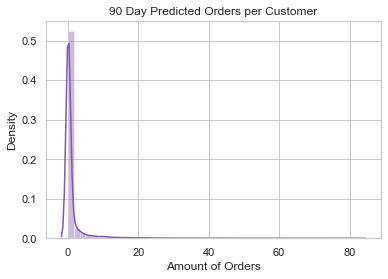

In [9]:
# helper function: predict each customer's purchases over next t days
def predict_purch(data, t):
        summary["predict_purch_" + str(t)] = \
                bgf.predict(
                    t, 
                    summary["frequency"], 
                    summary["recency"], 
                    summary["T"])
        
        
# call helper function: predict each customer's purchases over multiple time periods
t_FC = [10, 30, 60, 90]
_ = [predict_purch(summary, t) for t in t_FC]

pd.options.display.float_format = '{:,.1f}'.format



#histogram of the next 90 days of predicted purchases
ax = sns.distplot(summary["predict_purch_90"])#.set_xlim(0,8)
plt.title("90 Day Predicted " + transaction_name + " per " + customer_name)
plt.xlabel("Amount of " + transaction_name)


# helper function: probability of n repeat purchases within t days
def prob_purch(t, n):
    p = bgf.probability_of_n_purchases_up_to_time(t, n)
    return p
    

print(str(len(summary[summary["predict_purch_90"] >= 1])) + " (" + str(100 - summary["predict_purch_90"].quantile(1))[:5] + "%) " + customer_name +"s will make at least 1 " + transaction_name[:-1]) 
    
#top 10 customers over next 30 days
summary.sort_values(by="predict_purch_90", ascending=False).describe()

count   5,894.0
mean        7.8
std        10.1
min         1.0
25%         1.8
50%         3.7
75%         9.4
max        82.7
Name: predict_purch_90, dtype: float64

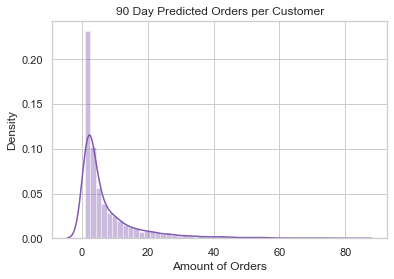

In [10]:
#histogram of the next 90 days of predicted purchases
ax = sns.distplot(summary[summary["predict_purch_90"] >= 1]["predict_purch_90"])#.set_xlim(0,8)
plt.title("90 Day Predicted " + transaction_name + " per " + customer_name)
plt.xlabel("Amount of " + transaction_name)

summary[summary["predict_purch_90"] >= 1]["predict_purch_90"].describe()

<AxesSubplot:xlabel='REPEATED ORDERS', ylabel='AOV'>

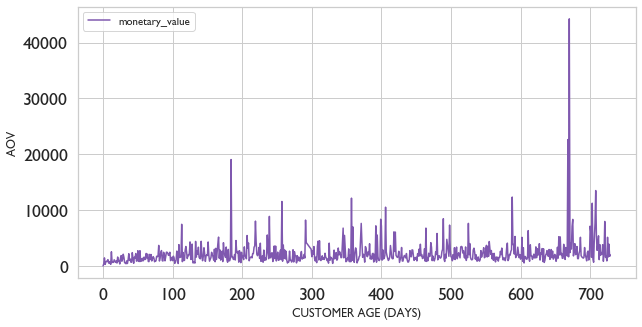

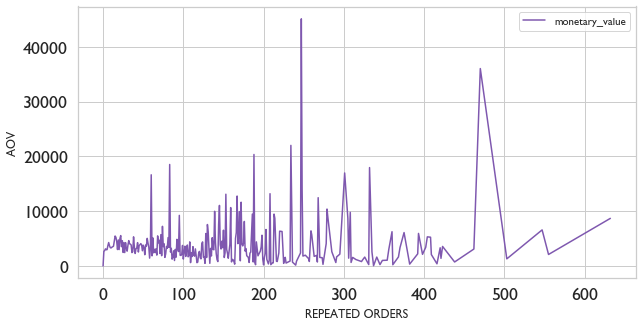

In [11]:
rc('font',**{'family':'sans-serif','sans-serif':['gill sans']})
rc('font',**{'family':'serif','serif':['gill sans']})
rc('text', usetex=False)

#get the average value per Age of Customer
AOV_Time = summary.groupby("T", as_index = True).mean()

#plot the AOV over time
AOV_Time.plot( y="monetary_value", fontsize = 18, figsize=(10,5), xlabel = customer_name.upper() +" AGE (DAYS)", ylabel = "AOV")


#get the AOV per repeated transaction
AOV_Transaction = summary.groupby("frequency", as_index = True).mean()

#plot the AOV per repeated transaction
AOV_Transaction.plot( y="monetary_value", fontsize = 18, figsize=(10,5), xlabel = "REPEATED "+ transaction_name.upper(), ylabel = "AOV")



<AxesSubplot:xlabel='REPEATED ORDERS', ylabel='AOV'>

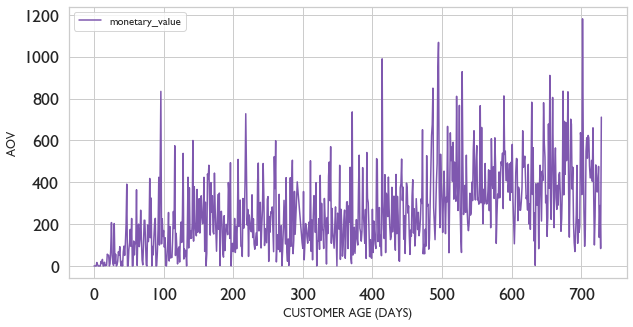

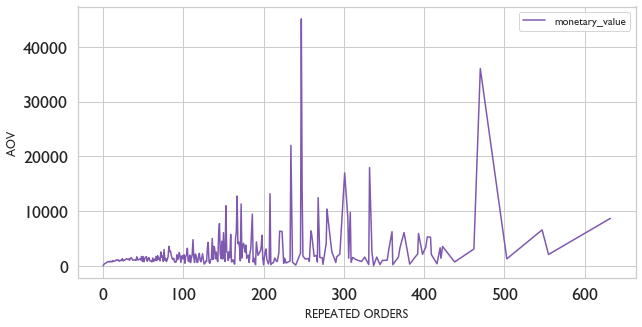

In [12]:
rc('font',**{'family':'sans-serif','sans-serif':['gill sans']})
rc('font',**{'family':'serif','serif':['gill sans']})
rc('text', usetex=False)

#get the average value per Age of Customer
AOV_Time = summary.groupby("T", as_index = True).median()

#plot the AOV over time
AOV_Time.plot( y="monetary_value", fontsize = 18, figsize=(10,5), xlabel = customer_name.upper() +" AGE (DAYS)", ylabel = "AOV")#, ylim = (0,100))

#get the AOV per repeated transaction
AOV_Transaction = summary.groupby("frequency", as_index = True).median()

#plot the AOV per repeated transaction
AOV_Transaction.plot( y="monetary_value", fontsize = 18, figsize=(10,5), xlabel = "REPEATED "+ transaction_name.upper(), ylabel = "AOV")



# Conditional Probability Alive

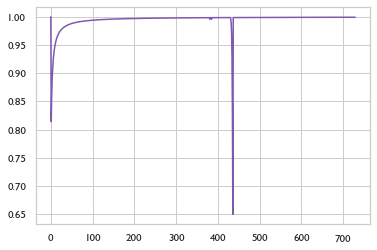

In [13]:
alive_path_in_T = calculate_alive_path(bgf,
                    transactions = data,
                    datetime_col = DATE_COLUMN,
                    t = 100,
                    freq = "D")

plt.plot(alive_path_in_T)
plt.show()


#alive_path_in_T

# Customer LifeTime Value using Gamma-Gamma Model

Pearson correlation: 0.012


,frequency,recency,T,monetary_value
USER_NO,,,,
20ade2494c626d9c489223c2293e3ed8808d5705784b8120a7aff3c5ad6e0462,1.000,2.000,670.000,"1,814,194.000"


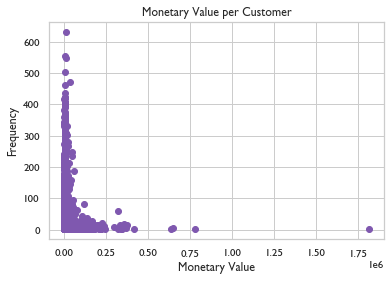

In [14]:
'''
The Gamma-Gamma Model assumes:
**THERE IS NO RELATIONSHIP BETWEEN THE MONETARY VALUE & THE PURCHASE FREQUENCY -
        Need to check to make sure the correlation between the two is close to 0.

-customers differ in their average transaction values
    for instance, some big spenders may have a propensity to spend twice as much per
    transaction as others

-the average monetary transaction value of an individual customer is time-invariant
    within the analytical horizon

-the values of the customer’s transactions vary around the mean while the mean itself
    remains stable over time
    
* The GG model only works for positive monetary values.
    *Must exclude any transactions with a unit negative or zerio price.
'''
pd.options.display.float_format = '{:,.3f}'.format



corr_matrix = returning_customers_summary[['monetary_value', 'frequency']].corr()
corr = corr_matrix.iloc[1,0]
print("Pearson correlation: %.3f" % corr)


returning_customers_summary_x = returning_customers_summary["monetary_value"]
returning_customers_summary_y = returning_customers_summary["frequency"]
plt.scatter(returning_customers_summary_x, returning_customers_summary_y)
plt.xlabel("Monetary Value")
plt.ylabel("Frequency")
plt.title("Monetary Value per " + customer_name)

# outlier
returning_customers_summary[returning_customers_summary["monetary_value"] == returning_customers_summary["monetary_value"].max()]

In [15]:
#apply GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef = 0)

ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'], 
        weights = None,   
        verbose = True,  
        tol = 1e-06,  
        q_constraint = False)
print(ggf)



# estimate the average transaction value of each customer, 
#based on frequency and monetary value
exp_avg_rev = ggf.conditional_expected_average_profit(
        frequency= returning_customers_summary["frequency"],
        monetary_value= returning_customers_summary["monetary_value"])

returning_customers_summary["exp_avg_rev"] = exp_avg_rev
returning_customers_summary["avg_rev"] = returning_customers_summary["monetary_value"]
returning_customers_summary["error_rev"] = returning_customers_summary["exp_avg_rev"] - returning_customers_summary["avg_rev"]

#mape = mean_absolute_percentage_error(exp_avg_rev, returning_customers_summary["monetary_value"])
#print("MAPE of predicted revenues:", f'{mape:.2f}')

pd.options.display.float_format = '{:,.3f}'.format
returning_customers_summary.describe()

Optimization terminated successfully.
         Current function value: 8.358120
         Iterations: 19
         Function evaluations: 20
         Gradient evaluations: 20
<lifetimes.GammaGammaFitter: fitted with 23726 subjects, p: 0.40, q: 0.85, v: 1075.71>


,frequency,recency,T,monetary_value,exp_avg_rev,avg_rev,error_rev
count,"23,726.000","23,726.000","23,726.000","23,726.000","23,726.000","23,726.000","23,726.000"
mean,13.784,138.054,386.066,"3,255.839","4,429.547","3,255.839","1,173.707"
std,31.380,175.304,215.841,"18,871.331","26,230.155","18,871.331","8,566.962"
min,1.000,1.000,1.000,0.010,17.054,0.010,2.943
25%,2.000,8.000,197.000,188.250,718.859,188.250,144.843
50%,4.000,55.000,393.000,623.772,"1,716.116",623.772,427.190
75%,12.000,213.000,582.000,"1,979.661","2,899.314","1,979.661","1,726.093"
max,632.000,726.000,729.000,"1,814,194.000","2,912,287.162","1,814,194.000","1,098,093.162"


,CLV,frequency,recency,T,monetary_value,exp_avg_rev,avg_rev,error_rev
count,"23,726.000","23,726.000","23,726.000","23,726.000","23,726.000","23,726.000","23,726.000","23,726.000"
mean,"19,142.157",13.784,138.054,386.066,"3,255.839","4,429.547","3,255.839","1,173.707"
std,"157,367.864",31.380,175.304,215.841,"18,871.331","26,230.155","18,871.331","8,566.962"
min,0.000,1.000,1.000,1.000,0.010,17.054,0.010,2.943
25%,1.830,2.000,8.000,197.000,188.250,718.859,188.250,144.843
50%,161.470,4.000,55.000,393.000,623.772,"1,716.116",623.772,427.190
75%,"3,118.590",12.000,213.000,582.000,"1,979.661","2,899.314","1,979.661","1,726.093"
max,"9,696,468.800",632.000,726.000,729.000,"1,814,194.000","2,912,287.162","1,814,194.000","1,098,093.162"


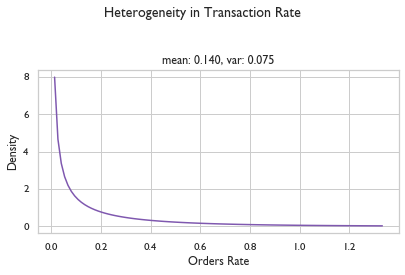

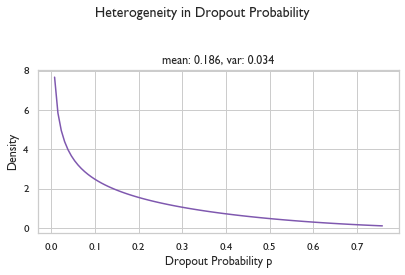

In [16]:
# compute customer lifetime value
DISCOUNT_a = 0.01  # annual discount rate
LIFE = 12    # lifetime expected for the customers in months

discount_m = (1 + DISCOUNT_a)**(1/12) - 1     # monthly discount rate

clv = round(ggf.customer_lifetime_value(
        transaction_prediction_model = bgf,  
        frequency = returning_customers_summary["frequency"],  
        recency = returning_customers_summary["recency"],  
        T = returning_customers_summary["T"],  
        monetary_value = returning_customers_summary["monetary_value"],  
        time = LIFE,    
        freq = freq,                          
        discount_rate = discount_m), 2)

clv.describe()

returning_customers_summary.insert(0, "CLV", clv)             # expected customer lifetime values


# Gamma distribution of lambda: customers' propensitiy to purchase
plot_transaction_rate_heterogeneity(model = bgf)  
plt.xlabel(transaction_name + " Rate")

# Beta distribution of p: customer's probability of dropping out immediately after a transaction
plot_dropout_rate_heterogeneity(model = bgf)

#export event names dataframe to a csv 
returning_customers_summary.to_csv("pclv_output.csv", index_label =CUSTOMER_ID_COLUMN)

#clv summary table of returning customers
returning_customers_summary.describe()